# Math 4383 Project
### Zachary Koenig, Colin Crippen

In [460]:
!pip install matplotlib
!pip install scikit-learn

Import statements
###### Note - only pulling dataset splitting and sample dataset from scikit-learn

In [461]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import csv
import time

Load the dataset and flatten the images for easy processing

Split into 80% training data, and reserve the remaining 20% for verification after training

In [462]:
digits = load_digits() # Load the 8x8 digits dataset

# The dataset contains 8x8 images and their corresponding digit labels.
# X contains image data and y contains the target labels.
IMAGES = digits.images      # Shape: (num_images, 8, 8)
LABELS = digits.target      # Shape: (num_images,)

# --- Data Preprocessing ---

# 1. Flatten the images:
#    Convert each 8x8 image into a 1D array of 64 pixels.
num_images = IMAGES.shape[0]
flattened_images = IMAGES.reshape(num_images, -1)   # Now shape is (num_images, 64)

# 2. Normalize the inputs:
#    The pixel values in the digits dataset are in the range 0-16.
#    Dividing by 16 scales them to the range [0, 1].
normalized_flat_images = flattened_images / 16.0

# 3. One-Hot Encode the Labels:
#    There are 10 classes (digits 0-9), so create one-hot encoded vectors.
num_classes = 10
labels_onehot = np.eye(num_classes)[LABELS]

# --- Split into Training and Verification (Validation) Sets ---
# For example, reserve 20% of the data for validation
image_train_set, image_validation_set, labels_train_set, labels_validation_set = train_test_split(
    normalized_flat_images, labels_onehot, test_size=0.2, random_state=4651
)

# Verify the shapes
print("Training set shape:")  # Should show ~80% of the samples
print(image_train_set.shape[0], 'images x', image_train_set.shape[1], 'pixels')
print(labels_train_set.shape[0], 'labels x', labels_train_set.shape[1], 'categories')
print("Validation set shape:") # Should show ~20% of the samples
print(image_validation_set.shape[0], 'images x', image_validation_set.shape[1], 'pixels')
print(labels_validation_set.shape[0], 'labels x', labels_validation_set.shape[1], 'categories')

Training set shape:
1437 images x 64 pixels
1437 labels x 10 categories
Validation set shape:
360 images x 64 pixels
360 labels x 10 categories


To enable nonlinear function representation, we'll use the "Sigmoid" and "reLU" activation functions

### Sigmoid Function:

$\sigma(x) = \Large\frac{1}{1 + e^{-x}}$

(where $x$ in this program is the weighted sum of the inputs plus the bias from the layer just processed)

- Squashes any real input into the interval $(0,1)$.
- Smooth and differentiable everywhere, which makes gradient‑based learning possible.

### Sigmoid Derivative:
$\sigma'(x) = \sigma(x)\,\bigl(1 - \sigma(x)\bigr)$

(where $x$ in this program is the weighted sum of the inputs plus the bias at the layer from the forward pass)

- Simple closed‑form in terms of $σ(x).$
- Used during backprop to propagate error gradients through the nonlinearity.

### ReLU Function:

$\mathrm{ReLU}(x) = \max(0,\,x)$

### ReLU Derivative:

$
\mathrm{ReLU}'(x) =
\begin{cases}
1 & \text{if } x > 0,\\
0 & \text{if } x \le 0.
\end{cases}
$

##### Why ReLU Is Useful in Neural Nets

1. **Sparsity of Activation**  
   - Negative inputs become zero, so many neurons are “off,” which can improve representational efficiency.

2. **Mitigation of Vanishing Gradients**  
   - For \(x>0\), the derivative is 1, helping gradients propagate without shrinking to near zero.

3. **Computational Simplicity**  
   - Only a comparison and selection are needed $(\max(0,x))$, making ReLU very fast to compute.

### Softmax Function
**Mathematical form:**  

$
\mathrm{softmax}(\mathbf{z})_i
= \Large\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}
$

(where)

### Safe Softmax Function
**Mathematical form (for a vector $\mathbf{z}\in\mathbb{R}^K$):**

$
\mathrm{softmax}(\mathbf{z})_i
= \Large\frac{e^{z_i - \max_j (z_j)}}
       {\sum_{k=1}^K e^{z_k - \max_j (z_j)}}
$


##### Risks of Standard Softmax:
- **Numerical overflow**  
   - If any $z_i$ is large $(e.g.\ \ z_i > 700)$, then $e^{z_i}$ can overflow to $\infty$.  
   - Subtracting $max_j (z_j)$ ensures the largest exponent is $e^0 = 1$, keeping all values in a safe range.

- **Numerical underflow**  
   - If all $z_i$ are very negative, $e^{z_i}$ can underflow to $0$.  
   - Centering by $max_j (z_j)$ prevents all exponentials from collapsing to $0$, preserving meaningful probability ratios.

##### Benefit of Safe Softmax
- Converts raw scores into a probability distribution over $K$ classes (they sum to 1).
- Subtracting $max_j (z_j)​$  ensures numerical stability.

In [463]:
# --- Activation functions and their derivatives ---

def sigmoid(x):
    """Compute the sigmoid activation."""
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    """Compute the derivative of the sigmoid function."""
    sigmoid_x = sigmoid(x)
    return sigmoid_x * (1 - sigmoid_x)

def softmax(x):
    """Computes the softmax function."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
    return e_x / e_x.sum(axis=1, keepdims=True)

def relu(x):
    """Compute the ReLU activation."""
    return np.maximum(0, x)

def relu_deriv(x):
    """Compute the derivative of the ReLU activation."""
    return np.where(x > 0, 1, 0)

In [464]:
# --- Hyperparameters ---
input_layer_size = 8 * 8   # 64 inputs, one per pixel
hidden_layer_size = 64       # You can adjust this
output_layer_size = 10       # 10 classes for digits 0-9

learning_rate = 0.1
epochs = 10_000

# Forward pass
---
The input to the network is a flattened image; in this case, the 8x8 pixel image is transformed into a 1x64 array, where each pixel is normalized for improved numerical stability.

The network has one hidden layer, which contains $n$ neurons.  Each neuron in the hidden layer has a weight, denoted as $\mathbf{W_{\text{input}}}$,​ and a bias, $\mathbf{b_{\text{input}}}$.

Initially, the weights are randomized, but these will be updated as the network trains. Alternatively, they could be systematically set or loaded from previously saved training data.

The first step involves multiplying each pixel value in the array by the corresponding weight of the first hidden layer neuron, and then summing those weighted values. After that, a bias term is added to the sum.

This process is repeated for each neuron in the hidden layer. For our test, we’ve set the hidden layer to have 64 neurons.

At this point, the process is similar to linear regression. However, to introduce non-linearity, we apply an activation function to each neuron's output in the hidden layer. In this program, we use the sigmoid and ReLU activation functions.

Similarly, the activated outputs from the hidden layer are linearly combined to form the inputs to the output layer. There are two key differences in this step:
1. The output layer consists of a number of neurons equal to the number of classification labels. In this case, the labels represent digits from 0 to 9, so there are 10 neurons in the output layer.
2. The activation function for the output layer is the Softmax function, which converts the raw output into a probability distribution over the 10 possible labels.

### Hidden Layer:

First, a linear transformation is applied to the input data with the weights and biases of the input layer.

$\mathbf{Z_1} = \mathbf{X} \cdot \mathbf{W_{\text{input}}} + \mathbf{b_{\text{input}}}$

where:

 - $\mathbf{X}$ is the input data.

 - $\mathbf{W_{\text{input}}}$​ is the matrix of weights for the input layer.

 - $\mathbf{b_{\text{input}}}$​ is the bias for the input layer.

 - $\mathbf{Z_1}$​ is the weighted sum of inputs.

Then, an activation function $f$ (such as ReLU, sigmoid, etc.) is applied to the output of this linear transformation:

$\mathbf{A_1} = f(\mathbf{Z_1})$

where $\mathbf{A_1}$​ is the activated output from the hidden layer.

### Output Layer:

A similar linear transformation is applied to the output from the hidden layer:

$\mathbf{Z_2} = \mathbf{A_1} \cdot \mathbf{W_{\text{hidden}}} + \mathbf{b_{\text{hidden}}}$

where:

 - $\mathbf{A_1}$ is the activation output from the hidden layer.

 - $\mathbf{W_{\text{hidden}}}$​ is the matrix of weights for the hidden layer.

 - $\mathbf{b_{\text{hidden}}}$​ is the bias for the hidden layer.

 - $\mathbf{Z_2}$​ is the weighted sum of the activations from the hidden layer.

Finally, the softmax activation is applied to the output $\mathbf{Z_2}$​ to obtain the predicted probabilities:

$\mathbf{A_2} = \text{softmax}(\mathbf{Z_2})$

where:

 - $\mathbf{A_2}$ is the output of the network, representing the probability distribution over the output classes.

# Backpropagation
---
The backward pass aims to update the weights and biases of the network by calculating the gradients of the loss with respect to each weight and bias, and then using these gradients to adjust the parameters.

The process begins by calculating the gradients for the output layer and then propagating those gradients backward to the hidden layer.

### Output Layer:
First, the gradient of the loss with respect to the output layer is computed. This is done using the softmax cross-entropy derivative, which simplifies as:

$\mathbf{dZ_2} = \mathbf{A_2} - \mathbf{target}$

where:

 - $\mathbf{A_2}$​ is the output from the network (the predicted probabilities).

 - $\mathbf{target}$ is the true class labels for the input data.


Next, the gradients of the weights and biases of the output layer are computed:

$\mathbf{dW_2} = \frac{1}{m} \cdot \mathbf{A_1}^T \cdot \mathbf{dZ_2}$​

$\mathbf{db_2} = \frac{1}{m} \cdot \sum \mathbf{dZ_2}$

where:

 - $m$ is the number of training examples.

 - $\mathbf{A_1}$​ is the activated output from the hidden layer (which acts as input to the output layer).

 - $\mathbf{dW_2}$​ represents the gradient of the weights in the output layer.

 - $\mathbf{db_2}$​ represents the gradient of the biases in the output layer.

### Hidden Layer:
Now, the gradients for the hidden layer are calculated by first computing the gradient of the loss with respect to the activations of the hidden layer:

$\mathbf{dA_1} = \mathbf{dZ_2} \cdot \mathbf{W_{\text{hidden}}}^T$

where:

 - $\mathbf{dZ_2}$ is the gradient from the output layer.

 - $\mathbf{W_{\text{hidden}}}$​ is the weight matrix for the hidden layer.

Then, the gradient of the weighted sum of inputs to the hidden layer is computed:

$\mathbf{dZ_1} = \mathbf{dA_1} \cdot f'(\mathbf{A_1})$

where: 

- $f'(\mathbf{A_1})$ is the derivative of the activation function applied to the hidden layer's output (e.g., sigmoid or ReLU).

Next, the gradients for the weights and biases of the hidden layer are computed:

$\mathbf{dW_1} = \frac{1}{m} \cdot \mathbf{data}^T \cdot \mathbf{dZ_1}$

$\mathbf{db_1} = \frac{1}{m} \cdot \sum \mathbf{dZ_1}$

where:

 - $\mathbf{data}$ is the input data.

 - $\mathbf{dW_1}$​ represents the gradient of the weights in the hidden layer.

 - $\mathbf{db_1}$​ represents the gradient of the biases in the hidden layer.


### Update Weights and Biases:
Finally, the weights and biases of both the hidden and output layers are updated using the computed gradients. This is done by calling the update_weights and update_biases functions, which adjust the weights and biases by a step proportional to the learning rate:

$\mathbf{W_1} \leftarrow \mathbf{W_1} - \text{learning\_rate} \cdot \mathbf{dW_1}$

$\mathbf{b_1} \leftarrow \mathbf{b_1} - \text{learning\_rate} \cdot \mathbf{db_1}$

$\mathbf{W_2} \leftarrow \mathbf{W_2} - \text{learning\_rate} \cdot \mathbf{dW_2}$

$\mathbf{b_2} \leftarrow \mathbf{b_2} - \text{learning\_rate} \cdot \mathbf{db_2}$

Where:

 - $\mathbf{W_1}, \mathbf{b_1}$​ are the weights and biases for the hidden layer.

 - $\mathbf{W_2}, \mathbf{b_2}$​ are the weights and biases for the output layer.

 - $\text{learning\_rate}$ is the step size used to update the weights and biases.

Through this process, the network learns by adjusting its parameters to minimize the loss function over time.



In [465]:
class NeuralNet:
    def __init__(self, save_name, input_layer_size, hidden_layer_size, output_layer_size, activ_func = sigmoid, activ_func_der = sigmoid_deriv):
        # --- Initialize Weights and Biases ---
        np.random.seed()
        self.save_name = save_name
        # Layer sizes
        self.input_layer_size = input_layer_size
        self.hidden_layer_size = hidden_layer_size
        self.output_layer_size = output_layer_size

        self.activation_function = activ_func
        self.activation_function_derivative = activ_func_der
        
        # Weights initialization
        self.input_layer_weights = np.random.randn(self.input_layer_size, self.hidden_layer_size) * 0.01
        self.input_layer_biases = np.zeros((1, self.hidden_layer_size))
        self.hidden_layer_weights = np.random.randn(self.hidden_layer_size, self.output_layer_size) * 0.01
        self.hidden_layer_biases = np.zeros((1, self.output_layer_size))
        
    def forward(self, data):
        """Forward pass through the network."""
        self.Z1 = np.dot(data, self.input_layer_weights) + self.input_layer_biases
        self.A1 = self.activation_function(self.Z1)  # Activation for hidden layer
        self.Z2 = np.dot(self.A1, self.hidden_layer_weights) + self.hidden_layer_biases
        self.A2 = softmax(self.Z2)  # Apply softmax activation in the output layer
        return self.A2
    
    def backward(self, data, target, learning_rate=0.01):
        """Backward pass: update weights and biases using gradients."""
        m = data.shape[0]  # Number of training examples

        # Calculate gradients for output layer (using softmax cross-entropy derivative)
        dZ2 = self.A2 - target  # Softmax cross-entropy derivative
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Calculate gradients for hidden layer (using sigmoid derivative)
        dA1 = np.dot(dZ2, self.hidden_layer_weights.T)
        dZ1 = dA1 * self.activation_function_derivative(self.A1)
        dW1 = np.dot(data.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.update_weights(dW1, dW2, learning_rate)
        self.update_biases(db1, db2, learning_rate)
    
    def update_weights(self, dW1, dW2, learning_rate):
        """Update weights using the gradients."""
        self.input_layer_weights -= learning_rate * dW1
        self.hidden_layer_weights -= learning_rate * dW2
        
    def update_biases(self, db1, db2, learning_rate):
        """Update biases using the gradients."""
        self.input_layer_biases -= learning_rate * db1
        self.hidden_layer_biases -= learning_rate * db2

    def predict(self, data):
        """Make predictions using the trained network."""
        return np.argmax(self.forward(data), axis=1)
    
    def save_progress(self):
        # Save the trained weights and biases to disk
        np.save('W1_' + self.save_name + '.npy', self.input_layer_weights)
        np.save('b1_' + self.save_name + '.npy', self.input_layer_biases)
        np.save('W2_' + self.save_name + '.npy', self.hidden_layer_weights)
        np.save('b2_' + self.save_name + '.npy', self.hidden_layer_biases)

# Cross‑Entropy Loss

**Mathematical form:**  
$
\mathcal{L} = -\frac{1}{m}\sum_{i=1}^m \sum_{k=1}^K y_{i,k}\,\log\bigl(A^{[2]}_{i,k} + \epsilon\bigr)
$

where $A^{[2]}_{i,k}$ is the output from the network

#### Why add a small constant $\epsilon$ for numerical stability

1. **Avoid $\log(0)\to -\infty$**  
   - If $A^{[2]}_{i,k}=0$, then $\log(0)$ is undefined.  
   - Adding $\epsilon$ ensures $\log\bigl(A^{[2]}_{i,k} + \epsilon\bigr)$ remains finite.

2. **Prevent NaNs and infinities in loss computation**  
   - Keeps the computed loss a real number even when predictions are exactly zero.

3. **Stable backpropagation**  
   - Ensures gradients remain well‑defined, avoiding infinite or undefined gradient values.

In [466]:
def calculate_loss(output):
    # Compute Cross-Entropy Loss (adding a small constant for numerical stability)
    return -np.mean(np.sum(labels_train_set * np.log(output + 1e-8), axis=1))

Helper function to calculate the number of correctly predicted labels in the neural network

Returns:
 - Accuracy of training data predictions
 - Accuracy of validation set predictions

In [467]:
def accuracy_check(nn, pred_output):
    # Training Accuracy (using the training forward pass already computed)
    train_preds = np.argmax(pred_output, axis=1)
    true_train_labels = np.argmax(labels_train_set, axis=1)
    train_accuracy = np.mean(train_preds == true_train_labels)

    # Validation: perform a forward pass over the validation set.
    validation_output = nn.forward(image_validation_set)
    val_preds = np.argmax(validation_output, axis=1)
    true_val_labels = np.argmax(labels_validation_set, axis=1)
    val_accuracy = np.mean(val_preds == true_val_labels)
    
    return (train_accuracy, val_accuracy)

### Training Loop
Start a timer to get time-to-train

**Repeat until number of epochs is satisfactory:**
- Feed-forward the image data (a set of flattened images)
- calculate the loss (single value for tracking approx. progress, true loss calculated in backpropigation)
- Back-propigate the difference between expected and predicted outputs
- (Occationally save data to document training progress)

Stop timer, document

Then, save progress data to a csv

In [468]:
def training_loop(neural_network):
    # --- Lists to Save Progress Data ---
    progress_data = []  # Each element: (epoch, loss, training set accuracy, validation set accuracy)
    
    start_time = time.time()
    for epoch in range(epochs):

        prediction_output = neural_network.forward(image_train_set)
        
        loss = calculate_loss(prediction_output)
        
        neural_network.backward(image_train_set, labels_train_set)

        # During training, sample 100 times to compute and record training accuracy and loss
        if epoch % max(1, epochs // 100) == 0:
            train_acc, val_acc = accuracy_check(neural_network, prediction_output)
            progress_data.append((epoch, loss, train_acc, val_acc))
            if epoch % 1000 == 0:
                print(f'Epoch: {epoch} Loss: {loss:.3f} Training Accuracy: {train_acc:.3f}')

    total_training_time = time.time() - start_time
    print(f"Total training time: {total_training_time:.2f} seconds")
    neural_network.save_progress()
    # Save progress data to CSV
    csv_filename = 'training_progress_' + neural_network.save_name + '.csv'
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["epoch", "loss", "train_accuracy", "val_accuracy"])
        for record in progress_data:
            writer.writerow(record)

Print sample image from validation set with image classification prediction

In [469]:
def test_single_image(neural_network):
    # --- Display and Test One Image ---
    # Select a random image from the validation set
    idx = np.random.randint(0, image_validation_set.shape[0])  # Fix: Correctly get the index
    img = image_validation_set[idx].reshape(8, 8)
    label = np.argmax(labels_validation_set[idx])

    # Save the image array to a file.
    np.save("test.npy", img)

    plt.imshow(img, cmap='gray')
    plt.title(f"Training Image - Digit: {label}")
    plt.axis('off')
    plt.show()

    # Load the test image.
    test_image = np.load('test.npy')

    # Flatten the image so that it has shape (1, 64)
    flat_test_image = test_image.reshape(1, -1)

    # Perform the forward pass to get the softmax output (probabilities)
    prediction_probs = neural_network.forward(flat_test_image)

    # Get the predicted class (index of the maximum probability)
    predicted_class = np.argmax(prediction_probs)

    # Calculate the confidence (probability of the predicted class)
    probability = np.max(prediction_probs)

    print("Predicted class:", predicted_class)
    print("Confidence: {:.2f}%".format(probability * 100))  # Correct confidence


Print % correct predictions out of validation set

In [470]:
def print_accuracy(neural_network):
    # --- Perform Predictions on the Validation Set Using the Loaded Weights ---
    predictions = neural_network.predict(image_validation_set)  # Fix the spelling of 'validation'

    # Calculate the accuracy of the model on the test set.
    # Convert the one-hot encoded labels to integer labels.
    true_labels = np.argmax(labels_validation_set, axis=1)

    # Accuracy Calculation
    accuracy = np.mean(predictions == true_labels)
    print("Test set accuracy: {:.2f}%".format(accuracy * 100))


Plot histogram of number of accurate/inaccurate guesses per confidence interval (0 - no confidence, 1 - total confidence)

In [471]:
def plot_confidence_comparison(probabilities, true_labels, bins=20, title = ''):
    """
    Plots histograms comparing the confidence scores for correctly vs.
    incorrectly classified samples.
    
    Parameters:
        probabilities (np.ndarray): A 2D array of shape (n_samples, n_classes) 
            containing the predicted probabilities (e.g., outputs of softmax).
        true_labels (np.ndarray): A 1D array of true labels (integers) of shape (n_samples,).
            If your labels are in one-hot format, convert them using np.argmax.
        bins (int): Number of bins for the histogram.
    """
    # Compute predicted labels (choose the class with the highest probability).
    predictions = np.argmax(probabilities, axis=1)
    
    # Compute the confidence for each prediction as the maximum probability.
    confidences = np.max(probabilities, axis=1)

    # Create consistent bin edges from 0 to 1.
    bin_edges = np.linspace(0, 1, bins + 1)
    
    # Separate confidence scores based on whether the prediction was correct.
    correct_confidences = confidences[predictions == true_labels]
    incorrect_confidences = confidences[predictions != true_labels]
    
    # Plot histograms for the two groups.
    plt.figure(figsize=(10, 6))
    plt.hist(correct_confidences, bins=bin_edges, alpha=0.7, label='Correct Predictions', color='green')
    plt.hist(incorrect_confidences, bins=bin_edges, alpha=0.7, label='Incorrect Predictions', color='red')
    plt.xlabel('Confidence')
    plt.ylabel('Number of Samples')
    plt.yscale("log")
    plt.title(title + ' Confidence Comparison: Correct vs. Incorrect Predictions')
    plt.legend()
    plt.show()

Plot loss, train accuracy, and verification accuracy as a function of number of epochs

In [472]:
def plot_training_progress(csv_filepath, title = ''):
    """
    Reads the CSV with training progress data (epoch, loss, training accuracy, validation accuracy)
    and plots the loss and accuracy curves. Loss is plotted on the left y-axis, while accuracy (both training
    and validation) is plotted on the right y-axis with training accuracy in red and validation accuracy in green.
    """
    epochs_list = []
    loss_list = []
    train_acc_list = []
    val_acc_list = []

    # Read data from the CSV
    with open(csv_filepath, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            epochs_list.append(float(row["epoch"]))
            loss_list.append(float(row["loss"]))
            train_acc_list.append(float(row["train_accuracy"]))
            val_acc_list.append(float(row["val_accuracy"]))

    # Create a new figure for each plot
    fig, ax1 = plt.subplots(figsize=(10, 6))  # New figure each time

    # Plot Loss on the left y-axis
    color_loss = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color_loss)
    ax1.plot(epochs_list, loss_list, marker='o', color=color_loss, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color_loss)

    # Create a second y-axis for the accuracies
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='black')
    ax2.plot(epochs_list, train_acc_list, marker='x', color='red', label='Train Accuracy')
    ax2.plot(epochs_list, val_acc_list, marker='x', color='green', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends from both axes and display
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    plt.title(title + ' Training Progress: Loss and Accuracy Every 100 Epochs')
    plt.tight_layout()
    plt.show()


Run the following block to test Sigmoid vs reLU hidden layer performance on the created test set with identical hyperparameters:

Epoch: 0 Loss: 2.304 Training Accuracy: 0.104
Epoch: 1000 Loss: 2.300 Training Accuracy: 0.143
Epoch: 2000 Loss: 2.296 Training Accuracy: 0.290
Epoch: 3000 Loss: 2.286 Training Accuracy: 0.305
Epoch: 4000 Loss: 2.259 Training Accuracy: 0.406
Epoch: 5000 Loss: 2.185 Training Accuracy: 0.550
Epoch: 6000 Loss: 2.016 Training Accuracy: 0.589
Epoch: 7000 Loss: 1.742 Training Accuracy: 0.632
Epoch: 8000 Loss: 1.451 Training Accuracy: 0.699
Epoch: 9000 Loss: 1.211 Training Accuracy: 0.756
Total training time: 27.33 seconds


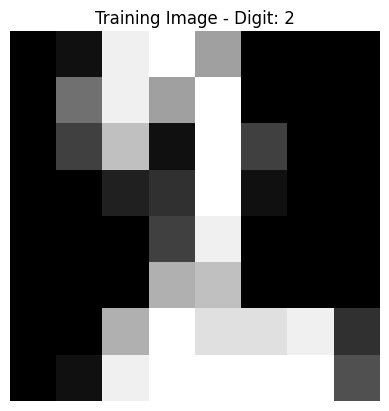

Predicted class: 2
Confidence: 47.37%
Test set accuracy: 73.06%
Epoch: 0 Loss: 2.303 Training Accuracy: 0.037
Epoch: 1000 Loss: 2.215 Training Accuracy: 0.477
Epoch: 2000 Loss: 1.314 Training Accuracy: 0.755
Epoch: 3000 Loss: 0.620 Training Accuracy: 0.890
Epoch: 4000 Loss: 0.385 Training Accuracy: 0.919
Epoch: 5000 Loss: 0.282 Training Accuracy: 0.935
Epoch: 6000 Loss: 0.224 Training Accuracy: 0.951
Epoch: 7000 Loss: 0.188 Training Accuracy: 0.958
Epoch: 8000 Loss: 0.163 Training Accuracy: 0.961
Epoch: 9000 Loss: 0.145 Training Accuracy: 0.965
Total training time: 19.62 seconds


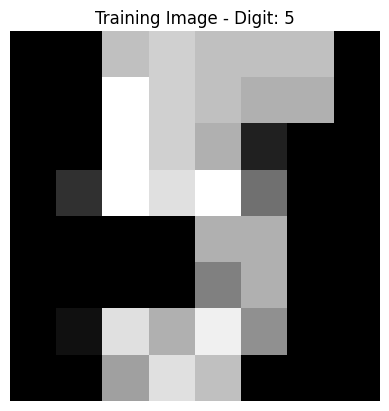

Predicted class: 5
Confidence: 90.41%
Test set accuracy: 95.00%


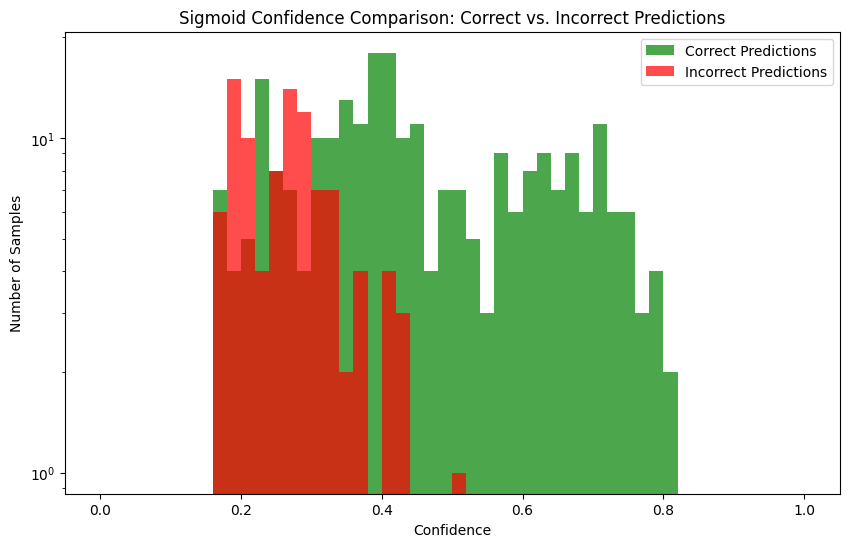

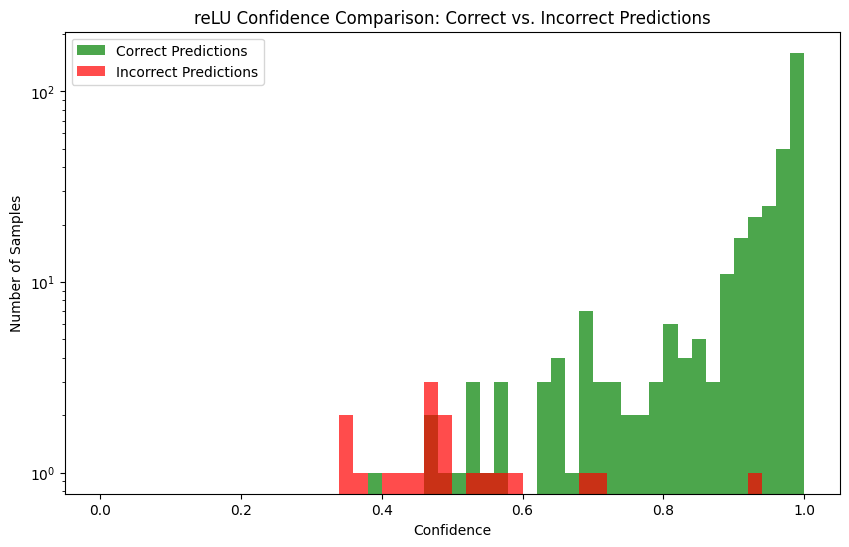

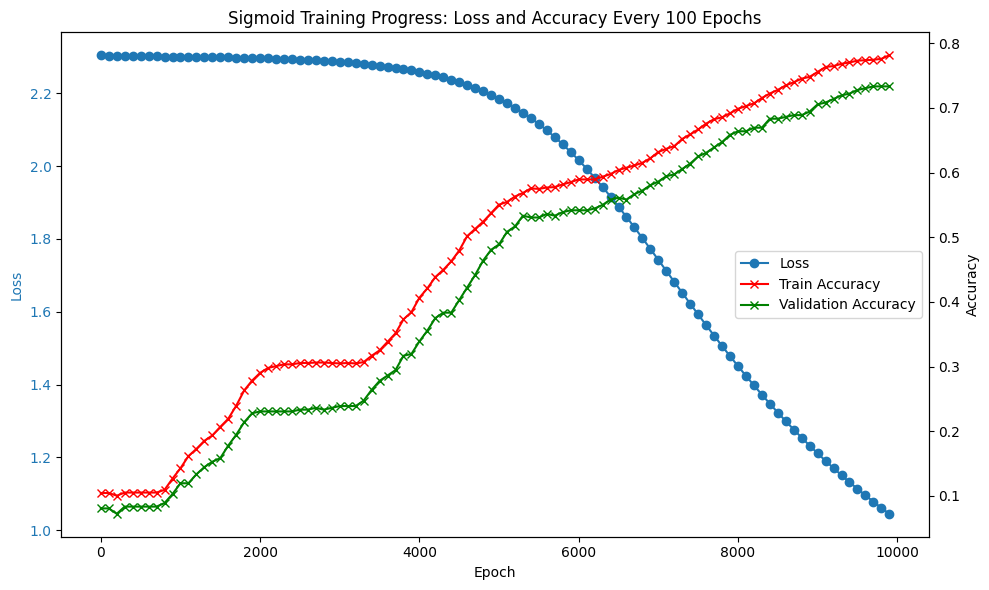

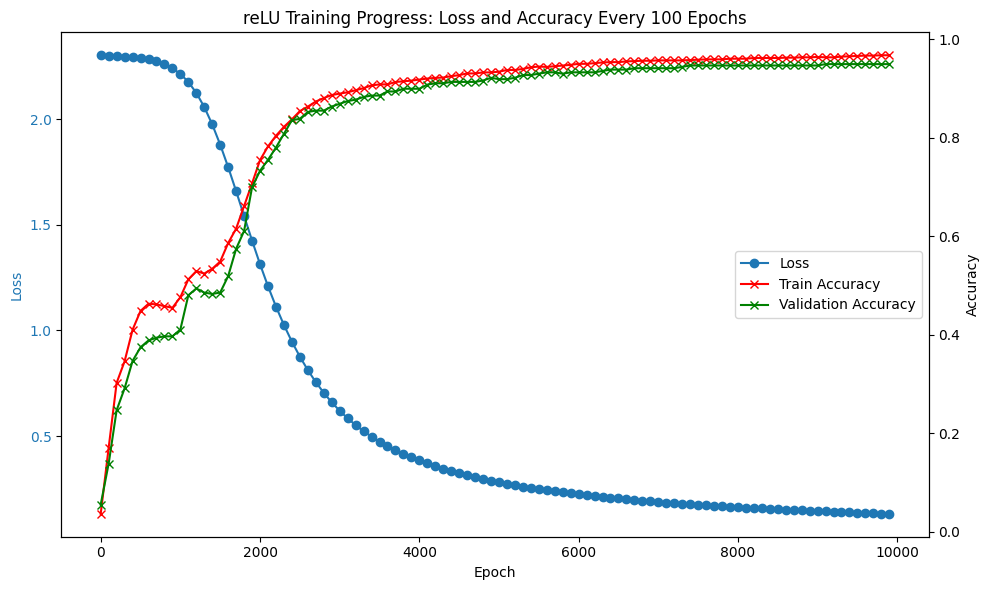

In [473]:
neural_network_sig = NeuralNet("sig", image_train_set.shape[1], 64, labels_train_set.shape[1])
neural_network_reLU = NeuralNet("reLU", image_train_set.shape[1], 64, labels_validation_set.shape[1], relu, relu_deriv)

training_loop(neural_network_sig)
test_single_image(neural_network_sig)
print_accuracy(neural_network_sig)

training_loop(neural_network_reLU)
test_single_image(neural_network_reLU)
print_accuracy(neural_network_reLU)

# Get the predicted probabilities (outputs of softmax)
predictions_output_sig = neural_network_sig.forward(image_validation_set)
predictions_output_reLU = neural_network_reLU.forward(image_validation_set)

# Plot the confidence comparison using the true labels
true_labels = np.argmax(labels_validation_set, axis=1)  # Convert one-hot to integer labels
plot_confidence_comparison(predictions_output_sig, true_labels, bins=50, title = 'Sigmoid')
plot_confidence_comparison(predictions_output_reLU, true_labels, bins=50, title ='reLU')

plot_training_progress('training_progress_' + neural_network_sig.save_name + '.csv', title = 'Sigmoid')
plot_training_progress('training_progress_' + neural_network_reLU.save_name + '.csv', title = 'reLU')